# Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

In this notebook, we will explore:
- applying DFA to neural time signals
- how DFA measures relate to different properties of neural time series
- compare DFA measures to other measures of 1/f. 



### Notes
- It looks like the expected relationship between DFA & 1/f appears to be true in the range of $\chi$ from -3 to 0. 
    - It seems like it breaks down with exponent of less than -3
    - It also doesn't seem to hold for exponents > 0
- The presence of an oscillations decreases measures DFA
    - Increasing the frequency of the oscillation further decreases measured DFA
    - Increasing the relative power of the oscillation further decreases measured DFA
- It would appear that given a combined signal, the measured DFA is upper-bound at the expected DFA given the exponent

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import *

from neurodsp.spectral import compute_spectrum
from fooof.plts import plot_spectra

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims
from apm.plts.settings import AP_COL, COMB_COL

In [4]:
from code.dfa import dfa

## Settings

In [5]:
# Simulation settings
n_seconds = 30
fs = 1000
default_exp = -2
default_freq = 10

# Collect together simulation parameters
sim_params_pow = {'n_seconds' : n_seconds, 'fs' : fs}

sim_params_comb = {'n_seconds' : n_seconds, 'fs' : fs,
                   'components' : {'sim_powerlaw' : {'exponent' : default_exp},
                                   'sim_oscillation' : {'freq' : default_freq}}}

# DFA settings
dfa_params = {
    'fs' : fs,
    'n_scales' : 10,
    'min_scale' : 0.1,
    'max_scale' : 2.0,
    'deg' : 1,
    'method' : 'dfa'
}

# Set the number of instances to run
n_instances = 10

# Set the exponent range to simulate across
exps = np.arange(-3, 0.25, 0.25)

freqs = np.arange(1, 50, 2)

pows = np.arange(0, 1, 0.1)

In [6]:
# Set the random seed
np.random.seed(111)

In [7]:
SAVE_FIG = True

## Helper Functions

In [8]:
def expected_alpha(exp):
    return (-exp + 1) / 2

In [9]:
def dfa_wrapper(sig, **kwargs):
    return dfa(sig, **kwargs)[2]

## DFA on Example Signals

### Powerlaw Signal

In [10]:
# Set an example exponent to simulate
exp = -2

In [11]:
# Simulate a powerlaw signal
sig_pl = sim_powerlaw(n_seconds, fs, exp)

In [12]:
# Calculat DFA on the simulated signal
_, _, dfa_res = dfa(sig_pl, **dfa_params)

In [13]:
# Check the calculate DFA exponent, and the expected value
print('DFA exponent: \t\t {:1.4f}'.format(dfa_res))
print('Expected Alpha:\t\t {:1.4f}'.format(expected_alpha(exp)))

DFA exponent: 		 1.5482
Expected Alpha:		 1.5000


### Knee Signal

In [14]:
# Expected exp
exp_kn = -2

In [15]:
sig_kn = sim_synaptic_current(n_seconds, fs)

In [16]:
scales, dfs, alpha = dfa(sig_kn, **dfa_params)

In [17]:
print('Measured Alpha:\t {:1.4f}'.format(alpha))
print('Expected Alpha:\t {:1.4f}'.format((-exp_kn + 1) / 2))

Measured Alpha:	 0.6466
Expected Alpha:	 1.5000


## DFA Across Exponents

In [18]:
# Run a set of simulations, calculating DFA across exponents
dfa_sims_exp = run_sims(sim_powerlaw, sim_params_pow, dfa_wrapper, dfa_params,
                        update='update_exp', values=exps, n_instances=n_instances)

In [19]:
# Run a set of simulations, calculating DFA across exponents, with an oscillation
dfa_sims_comb_exp = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                             update='update_comb_exp', values=exps, n_instances=n_instances)

In [20]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected = [expected_alpha(exp) for exp in exps]

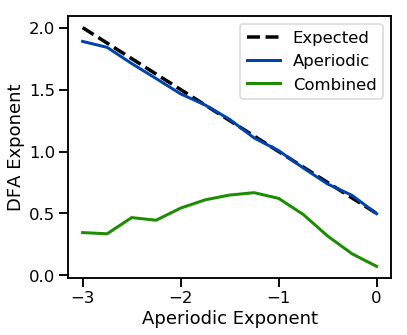

In [21]:
# Plot DFA measures
_, ax = plt.subplots(figsize=(6, 5))
plt.plot(exps, expected, '--k', label='Expected', lw=3.5);
plt.plot(exps, dfa_sims_exp, label='Aperiodic', lw=3, color=AP_COL);
plt.plot(exps, dfa_sims_comb_exp, label='Combined', lw=3, color=COMB_COL);

plt.xlabel('Aperiodic Exponent')
plt.ylabel('DFA Exponent')

plt.legend()

plt.tight_layout()

if SAVE_FIG: plt.savefig('plts/dfa-both.pdf')

In [22]:
# Run a set of simulations, calculating DFA across oscillation frequencies
dfa_sims_freq = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

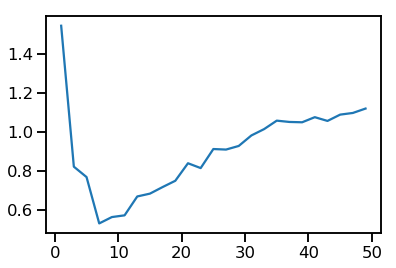

In [23]:
# Plot DFA measures across oscillation frequency values
plt.plot(freqs, dfa_sims_freq)

In [24]:
# Run a set of simulations, calculating DFA across oscillation power
dfa_sims_pow = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_pow', values=pows, n_instances=n_instances)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


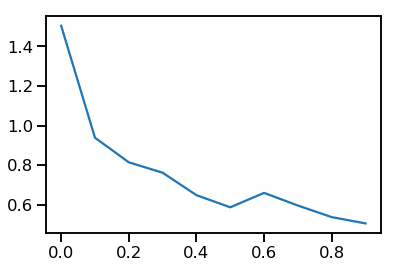

In [25]:
# Plot DFA measures across oscillation power values
plt.plot(pows, dfa_sims_pow)